In [353]:
import pennylane as qml 

In [354]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def guess_the_unitary(unitary):
    qml.Hadamard(0)
    qml.ctrl(qml.QubitUnitary(unitary, wires=[1]), control=[0])
    qml.Hadamard(0)
    return qml.probs(wires=0)

U = qml.PauliZ.compute_matrix() 

# -Z gate
# U = (-1)*qml.PauliZ.compute_matrix()

print(qml.QNode(guess_the_unitary, dev)(U))
# qml.draw_mpl(guess_the_unitary)(U)


[1. 0.]


### phase kickback 

In [355]:
dev = qml.device("default.qubit", wires=2)
        
@qml.qnode(dev)
def phase_kickback_X(eigenvector):
    if eigenvector == 'minus':
        qml.PauliX(0)
    
    qml.Hadamard(0)
    qml.ctrl(qml.PauliZ, control=0)(wires=1)
    qml.Hadamard(0)

    return qml.probs(wires=[0])   

print(phase_kickback_X("plus"))
print(phase_kickback_X("minus"))

# MODIFY EIGENVALUES BELOW 
eigenvalue_of_X_plus = 1
eigenvalue_of_X_minus = -1

qml.draw_mpl(phase_kickback_X, wires=[0,1])


[1. 0.]
[0. 1.]


<function __main__.phase_kickback_X(eigenvector)>

### Estimate phase of T gate

[0.   0.   0.25 0.   0.   0.   0.   0.  ] [(1+0j), (1+0j), 1j, (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]


(<Figure size 800x500 with 1 Axes>, <Axes: >)

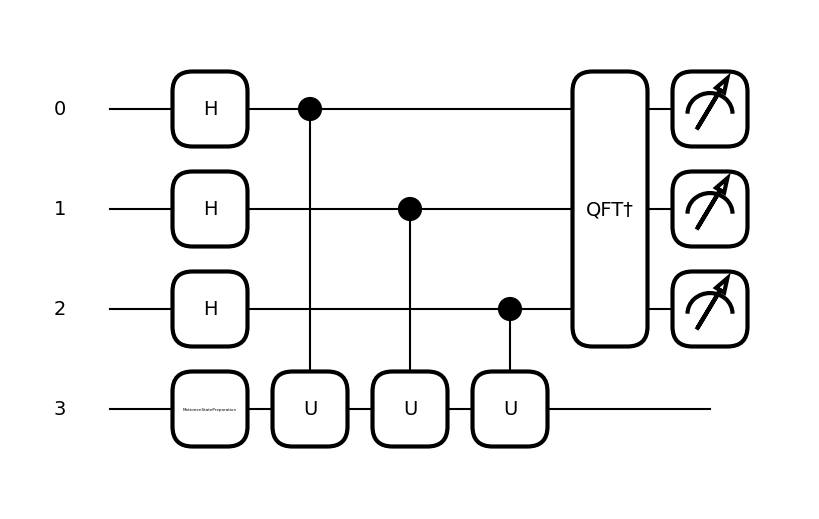

In [356]:
import numpy as np

estimation_wires = [0, 1,2]
target_wires = [3]

def U_power_2k(unitary, k):
    return np.linalg.matrix_power(unitary, 2**k)

def apply_controlled_powers_of_U(unitary):
    p = len(estimation_wires)
    for wire in range(p):
        u = U_power_2k(unitary, (p-wire-1))
        qml.ctrl(qml.QubitUnitary(u, wires=target_wires), control=wire)

dev = qml.device('default.qubit', wires=len(estimation_wires)+len(target_wires))

def prepare_eigenvector(state):
    state = state/np.linalg.norm(state)
    qml.MottonenStatePreparation(state, wires=target_wires)
    # qml.PauliX(wires=target_wires)

def binary2decimal(probs):
    pval = [1/2**i for i in range(1,len(estimation_wires)+1)]
    res = []
    for index,p in enumerate(probs):
        s = 0
        for idx,val in enumerate(bin(2**len(estimation_wires)+index)[3:]):
            s+=int(val)*pval[idx]
        res.append(float(s*p))
    return res
    
def estimate_phase(probs):
    return binary2decimal(probs)

@qml.qnode(dev)
def qpe(unitary):
    prepare_eigenvector([0,1])
    for i in estimation_wires:
        qml.Hadamard(i)
    apply_controlled_powers_of_U(unitary)
    qml.adjoint(qml.QFT)( wires=estimation_wires)
    return qml.probs(wires=estimation_wires)
U = qml.S.compute_matrix()
probs = qpe(U)
estimated_phasev = estimate_phase(probs)
estimated_phasev = np.round(estimated_phasev, 10)
print (estimated_phasev, [np.round(np.exp(1j*2*np.pi*est),3) for est in estimated_phasev])
qml.draw_mpl(qpe)(U)


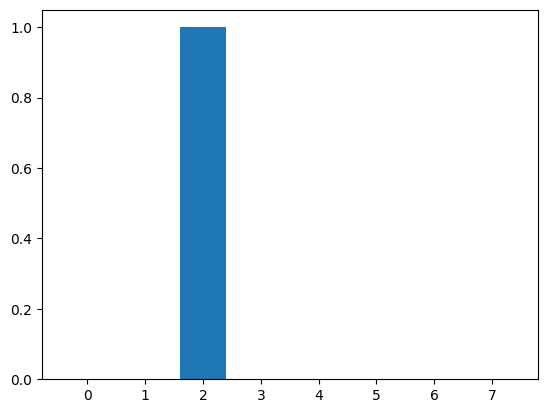

In [357]:
import matplotlib.pyplot as plt

plt.bar(range(2**3), probs)
plt.show()

### P3 Rational number bounds

In [358]:
dev = qml.device("default.qubit", wires=10)

def fractional_binary_to_decimal(binary_fraction, wires):
    return float(binary_fraction/ 2 ** len(wires))

def binary2decimal(probs, estimation_wires):
    pval = [1/2**i for i in range(1,len(estimation_wires)+1)]
    res = []
    for index,p in enumerate(probs):
        s = 0
        for idx,val in enumerate(bin(2**len(estimation_wires)+index)[3:]):
            s+=int(val)*pval[idx]
        res.append(float(s))
    return res
    
def estimate_phase(probs, estimation_wires):
    return binary2decimal(probs,estimation_wires)
    
def phase_window(probs, estimation_wires):
    p = sorted(zip(probs, estimate_phase(probs, estimation_wires)), key=lambda x: x[0])
    bound_1 = p[-1][1]
    bound_2 = p[-2][1]
    return (bound_1, bound_2)

# Test your solution

# You can increase the number of estimation wires to a maximum of range(0, 9)
estimation_wires = range(0, 9)

# The target is set to the last qubit
target_wires = [9]

# Define the unitary
U = np.array([[1, 0], [0, np.exp((2*np.pi*1j/7))]])

probs = qpe(U, estimation_wires, target_wires)

print(phase_window(probs, estimation_wires))

# MODIFY TO TRUE AFTER TESTING YOUR SOLUTION
done = True


TypeError: qpe() takes 1 positional argument but 3 were given